# SkillFactory. Data Science. Проект №3.

### Задача: предсказать рейтинг ресторанов в TripAdvisor.


# Загрузка и инициализация 

## Библиотеки

In [815]:
import numpy as np
import pandas as pd
from collections import Counter
import re
import seaborn as sns
import missingno as missin
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from datetime import datetime, timedelta
from textblob import TextBlob

In [816]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/world-cities/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/world-capitals-gps/concap.csv
/kaggle/input/countries-of-the-world/countries of the world.csv


In [817]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

## Датасеты

Загружаются следующие датасеты:
1. **df_train** - дата о ресторанах, на котором тренирую модель;
2. **df_test** - дата о ресторанах, на которых тестирую модель;
3. **data** - объединенный df_train и df_test, который анализирую, чищу и дополняю информацией;
4. **sample_submission** - пример отправки;
5. **cities**, **concap.csv**, **worlcities.csv** - датасеты о городах и странах, добавленные с kaggle дополнительно для создания новых признаков.


### main_task.csv, kaggle_task.csv, sample_submission.csv 
 Предоставленные датасеты, содержащие информацию о ресторанах. 

In [818]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

Подгоняю названия полей под стандарт PEP8.

In [819]:
for dataset in [df_train, df_test, sample_submission]:
    dataset.columns = list(map(lambda x: (x.replace(' ', '_')).lower(), dataset.columns))

Для корректной обработки признаков объединяю трейн и тест в один датасет

Помечаю трейн sample = 1

Выставляю rating = 0 в тесте нам его нужно предсказать.

In [820]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [821]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


#### Разъяснение признаков
* **restaurant_id**: ID ресторана
* **city**: Город 
* **cuisine_style**: Кухня
* **ranking**: Ранг ресторана относительно других ресторанов в этом городе
* **price_range**: Цены в ресторане в 3 категориях
* **number_of_reviews**: Количество отзывов
* **reviews**: 2 последних отзыва и даты этих отзывов
* **url_ta**: страница ресторана на 'www.tripadvisor.com' 
* **id_ta**: ID ресторана в TripAdvisor
* **rating**: Рейтинг ресторана

In [822]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
2868,id_2868,Oporto,"['European', 'Portuguese']",1286.0,$,26.0,"[['Good service and dishes', 'Cheap & cheerful...",/Restaurant_Review-g189180-d6600129-Reviews-Re...,d6600129,0,0.0
16862,id_7017,Paris,['Thai'],7018.0,$$ - $$$,30.0,"[['Beautiful!', 'love this place'], ['11/03/20...",/Restaurant_Review-g187147-d2721571-Reviews-Ma...,d2721571,1,4.0
42387,id_1545,Lyon,NaN,1546.0,NaN,13.0,"[['A delicious first meal in Lyon'], ['12/21/2...",/Restaurant_Review-g187265-d5981654-Reviews-Vi...,d5981654,1,4.5
6017,id_6017,Ljubljana,"['Mediterranean', 'European', 'Slovenian', 'Ce...",23.0,$$ - $$$,1182.0,"[['Excellent', 'Cosy Bistro'], ['01/09/2018', ...",/Restaurant_Review-g274873-d1858692-Reviews-Ma...,d1858692,0,0.0
12229,id_264,Munich,"['Mediterranean', 'European', 'Greek', 'Seafoo...",266.0,$$ - $$$,52.0,"[['The best Greek restaurant in Munich', 'AMAZ...",/Restaurant_Review-g187309-d2264460-Reviews-Th...,d2264460,1,4.5


### worldcities.csv
Датасет для добавления таких признаков, как страна и популяция.

In [823]:
cities = pd.read_csv('../input/world-cities/worldcities.csv')
cities = cities[['city', 'country', 'population']].copy().set_index('city')
cities.sample(10)

,country,population
city,,
Morshansk,Russia,39362.0
Montpelier,United States,7372.0
Gelnica,Slovakia,6099.0
Berehove,Ukraine,23732.0
P’yŏng-dong,"Korea, North",236583.0
Homer Glen,United States,24472.0
McPherson,United States,12989.0
Colombes,France,85177.0
Al Mubarraz,Saudi Arabia,298562.0


### countries of the world.csv
Датасет для добавления признаков о стране.

In [824]:
countries = pd.read_csv('../input/countries-of-the-world/countries of the world.csv')
countries = countries[[
    'Country',
    'Coastline (coast/area ratio)',
    'GDP ($ per capita)',
    'Phones (per 1000)',
    'Agriculture',
    'Service'
]].copy()
countries.columns = ['country', 'coastline', 'gdp', 'phones', 'agriculture', 'service']
countries = countries.set_index('country')
countries.index = countries.index.str.strip()
countries.sample(10)

,coastline,gdp,phones,agriculture,service
country,,,,,
Moldova,"0,00",1800.0,"208,1","0,213","0,555"
Belgium,"0,22",29100.0,"462,6","0,01","0,749"
Ireland,"2,06",29600.0,"500,5","0,05","0,49"
Brazil,"0,09",7600.0,"225,3","0,084","0,516"
Burkina Faso,"0,00",1100.0,"7,0","0,322","0,482"
Swaziland,"0,00",4900.0,"30,8","0,119","0,366"
"Gambia, The","0,71",1700.0,"26,8","0,308","0,549"
Cook Islands,"50,00",5000.0,"289,9","0,151","0,753"
Jamaica,"9,30",3900.0,"124,0","0,049","0,615"


### concap.csv
Датасет для добавления признака столицы.

In [825]:
capitals = pd.read_csv('../input/world-capitals-gps/concap.csv')
capitals = capitals[['CountryName', 'CapitalName']]
capitals.columns = ['country', 'capital']
capitals = capitals.set_index('country')
capitals.index = capitals.index.str.strip()
capitals.sample(10)

,capital
country,
Falkland Islands,Stanley
Tanzania,Dar es Salaam
Lithuania,Vilnius
Italy,Rome
Uganda,Kampala
Western Sahara,El-Aaiún
Norway,Oslo
Saint Barthelemy,Gustavia
New Zealand,Wellington


# Предобработка данных и РАД

## 0. Полезные функции

Найти самый часто встречающийся вид кухни по странам или городам.

In [826]:
def common_cuisine(data_frame, country_or_city, by_country=True):
    column_name = 'country' if by_country else 'city'
    return data_frame[data_frame[column_name] == country_or_city]['cuisine_style'].value_counts().index[0]

Распарсить ревью поля

In [827]:
def parse_reviews(df):
    df['reviews'].fillna('[[], []]', inplace=True)
    df['tmp_reviews'] = df['reviews'].apply(lambda x: x.split('],')[0].split("',"))

    df['review_1'] = df['tmp_reviews'].apply(lambda x: x[0])
    df['review_2'] = df['tmp_reviews'].apply(lambda x: x[-1])
    df['review_1'] = df['review_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', '')
    )
    df['review_2'] = df['review_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', '')
    )
    df.drop('tmp_reviews', axis=1, inplace=True)

    # remove duplicates
    df['review_2'] = df[['review_2', 'review_1']].apply(
        lambda x: '' if x[0] == x[1] else x[0],
        axis=1
    )
    
    df['review_ton_1'] = df['review_1'].apply(lambda x: TextBlob(x).polarity)
    df['review_ton_2'] = df['review_2'].apply(lambda x: TextBlob(x).polarity)

    df['tmp_days_reviews'] = df['reviews'].apply(lambda x: x.split('],')[-1].split("',"))
    df['day_1'] = df['tmp_days_reviews'].apply(lambda x: x[0])
    df['day_2'] = df['tmp_days_reviews'].apply(lambda x: x[-1])
    df['day_1'] = df['day_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', '')
    )
    df['day_2'] = df['day_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', '')
    )
    df.drop('tmp_days_reviews', axis=1, inplace=True)

    # remove duplicates
    df['day_2'] = df[['day_2', 'day_1']].apply(
        lambda x: '' if x[1] == '' else x[0],
        axis=1
    )

    # format dates
    df['day_1'] = df['day_1'].apply(lambda x: x if len(x) == 0 else datetime.strptime(x, '%m/%d/%Y'))
    df['day_2'] = df['day_2'].apply(lambda x: x if len(x) == 0 else datetime.strptime(x, '%m/%d/%Y'))
    
    df['reviews_days_diff'] = abs(df['day_1'] - df['day_2']).apply(lambda x: x.days)

Вычислить разницу в количестве днях между двумя входящими датами.

Подсчитать квартили и выбросы IQR для поля

In [828]:
def iqr_for_column(data, column):
    perc_25 = data[column].quantile(0.25)
    perc_75 = data[column].quantile(0.75)
    iqr = perc_75 - perc_25
    min_out = perc_25 - 1.5 * iqr
    max_out = perc_75 + 1.5 * iqr
    anomaly = len(data[data[column] > max_out]) + len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc_25),
        '75-й перцентиль: {} |'.format(perc_75),
        "IQR: {} | ".format(iqr),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print(
        "Выбросов, согласно IQR: {} | {:2.2%}".format(
            anomaly,
            anomaly / len(data)
        )
    )

## 1. Обработка неизвестных значений NaN и создание новых признаков.
### 1.1 Перед обработкой NAN  выношу информацию о наличии пропусков как отдельный признак.  

Отображаю матрицу неизвестных значений.

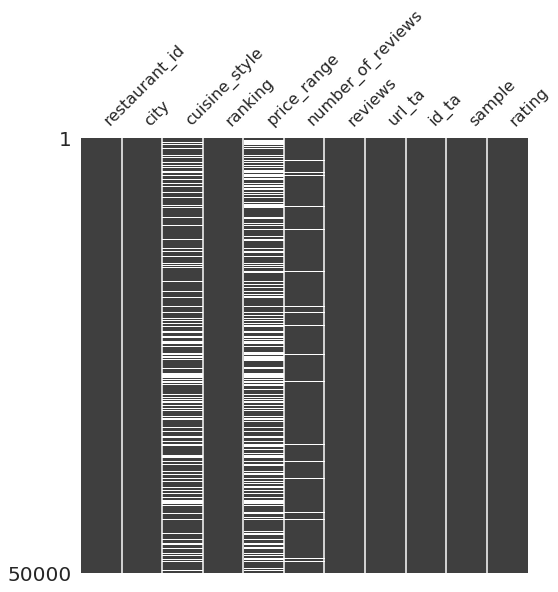

In [829]:
fig, ax = plt.subplots(figsize=(8, 8))
missin.matrix(data, ax=ax, sparkline=False)

Нахожу столбцы с неизвестными значениями.

In [830]:
cols_with_nans = (data.isnull().any()[lambda column: column]).index
cols_with_nans

Index(['cuisine_style', 'price_range', 'number_of_reviews', 'reviews'], dtype='object')

Создаю новый бинарный признак для каждого столбца с неизвестными значениями о наличии пропусков.

In [831]:
for col in cols_with_nans:
    new_col_name = col + '_is_nan'
    data[new_col_name] = pd.isna(data[col]).astype('uint8')

### 1.2 Разбор столбцов с NaN по отдельности: замена NaN значений и создание взаимосвязанных новых признаков.
Неизвестные значения имеются в стобцах **cuisine_style**, **price_range**, **number_of_reviews** и **reviews**.

Рассмотриваю каждый из них по отдельности.

Также, дополнительно создаю новые признаки такие, как **country** и **cuisine_count**.

#### Признак country

Создаю и заполняю новый признак country в датасете по городам.

In [832]:
data['country'] = pd.Series(np.array([None] * data.shape[0]))

for name in data.city.unique():
    if name in cities.index:
        try:
            data.loc[(data.city == name), 'country'] = cities.loc[name].country
        except:
            data.loc[(data.city == name), 'country'] = cities.loc[name].country.values[0]

Проверяю заполнен ли country полностью.

In [833]:
data[data.country.isnull()]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country
66,id_66,Oporto,NaN,878.0,NaN,7.0,"[[], []]",/Restaurant_Review-g189180-d11667248-Reviews-C...,d11667248,0,0.0,1,1,0,0,None
84,id_84,Krakow,"['Polish', 'Eastern European', 'European', 'Ce...",251.0,$$ - $$$,95.0,"[['The right choice', 'Excellent Polish cuisin...",/Restaurant_Review-g274772-d3331669-Reviews-Go...,d3331669,0,0.0,0,0,0,0,None
124,id_124,Krakow,NaN,936.0,NaN,6.0,"[[], []]",/Restaurant_Review-g274772-d10455057-Reviews-R...,d10455057,0,0.0,1,1,0,0,None
128,id_128,Zurich,NaN,1592.0,NaN,14.0,"[['Cordon Bleu'], ['10/02/2014']]",/Restaurant_Review-g188113-d4961508-Reviews-Re...,d4961508,0,0.0,1,1,0,0,None
144,id_144,Zurich,"['Swiss', 'European', 'Central European']",1101.0,$$ - $$$,99.0,"[['Nice atmosphere', 'Good views, but medium f...",/Restaurant_Review-g188113-d2013573-Reviews-Al...,d2013573,0,0.0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49825,id_433,Zurich,"['Mediterranean', 'Swiss', 'European', 'Vegeta...",436.0,$$ - $$$,33.0,"[['Hammer!', 'Favourite!'], ['11/15/2017', '10...",/Restaurant_Review-g188113-d10124292-Reviews-S...,d10124292,1,4.5,0,0,0,0,None
49852,id_360,Zurich,"['Chinese', 'Fast Food', 'Asian', 'Vegetarian ...",362.0,$,41.0,"[['Superb Take away place', 'Super good'], ['0...",/Restaurant_Review-g227102-d6675094-Reviews-Ch...,d6675094,1,4.5,0,0,0,0,None
49873,id_430,Oporto,"['European', 'Portuguese']",431.0,$,65.0,"[['yummy and huge francesinha', 'The best fran...",/Restaurant_Review-g189180-d10146257-Reviews-A...,d10146257,1,4.0,0,0,0,0,None
49895,id_871,Oporto,"['Bar', 'European', 'Pub', 'Portuguese']",872.0,$,141.0,"[['Football on TV', 'Nice place for a glass of...",/Restaurant_Review-g189180-d7315906-Reviews-Cr...,d7315906,1,3.5,0,0,0,0,None


Заполняю вручную отстутствующие значения для новых признаков.

In [834]:
data.loc[(data.city == 'Oporto'), 'country'] = 'Portugal'
data.loc[(data.city == 'Zurich'), 'country'] = 'Switzerland'
data.loc[(data.city == 'Krakow'), 'country'] = 'Poland'

data[data.country.isnull()]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country


#### Признак cuisine_style и cuisine_count

**23% (11590) неизвестных значений** 

В данном столбце каждая ячейка - строка.

Преобразую формат ячеек из строки в настоящий лист со строками.

Посчитаю процентное соотношение неизвестных значений.

In [835]:
stats = data['cuisine_style'].isnull().value_counts()
print(stats)
print(100 * stats[1] / (stats[0] + stats[1]))

False    38410
True     11590
Name: cuisine_style, dtype: int64
23.18


Привожу формат ячейки из формата строки в формат листа, состоящего из строк.

In [836]:
df_cuisine_style = pd.DataFrame(data['cuisine_style'])
df_cuisine_style['cuisine_style'] = df_cuisine_style['cuisine_style'].str.strip('[]')
df_cuisine_style['cuisine_style'] = df_cuisine_style['cuisine_style'].str.replace('\'', '')
data['cuisine_style'] = df_cuisine_style['cuisine_style'].str.split(', ')

Чтобы найти самую часто встречающуюся кухню нужно использовать ***explode***.
Для этого создаю копию датасета df_cuisine_style_explode, чтобы не повлияло на оригинал.

In [837]:
df_cuisine_style_explode = data.explode('cuisine_style')
df_cuisine_style_explode.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country
35869,id_1080,Brussels,NaN,1081.0,NaN,8.0,"[['Reccomended'], ['09/02/2017']]",/Restaurant_Review-g1136501-d11926312-Reviews-...,d11926312,1,4.5,1,1,0,0,Belgium
727,id_727,Edinburgh,Gluten Free Options,141.0,$$ - $$$,310.0,"[['Great food! Excellent customer service!', '...",/Restaurant_Review-g186525-d10497840-Reviews-T...,d10497840,0,0.0,0,0,0,0,United Kingdom
8604,id_8604,London,Mediterranean,10834.0,$$ - $$$,32.0,"[['Evening with Friends', 'Just good'], ['05/1...",/Restaurant_Review-g186338-d1092933-Reviews-Le...,d1092933,0,0.0,0,0,0,0,United Kingdom
47111,id_1361,Brussels,Italian,1362.0,$$$$,6.0,"[['Excellent! Amazing and real Italian food', ...",/Restaurant_Review-g188644-d13140285-Reviews-N...,d13140285,1,4.5,0,0,0,0,Belgium
46503,id_2527,Prague,International,2533.0,$$ - $$$,27.0,"[['OK', 'Breakfast buffet'], ['06/20/2017', '0...",/Restaurant_Review-g274707-d4767978-Reviews-Re...,d4767978,1,3.5,0,0,0,0,Czechia


In [838]:
data[data.cuisine_style_is_nan == 1].head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,1,1,1,0,Hungary
10,id_10,Rome,NaN,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,1,1,0,0,Italy
13,id_13,Hamburg,NaN,1000.0,NaN,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,0.0,1,1,0,0,Germany
18,id_18,Vienna,NaN,3360.0,NaN,2.0,"[[], []]",/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,0.0,1,1,0,0,Austria
20,id_20,Barcelona,NaN,6085.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,0.0,1,1,0,0,Spain


Заполняю неизвестные значения самой популярной кухней в городе. Можно попробовать по странам, но лучше распределение получилось по городам.

In [839]:
for name in data.city.unique():
    cuisine = common_cuisine(df_cuisine_style_explode, name, by_country=False)
    data.loc[(data.city == name) & (data.cuisine_style_is_nan == 1), 'cuisine_style'] = cuisine

In [840]:
data.cuisine_style_is_nan.value_counts()

0    38410
1    11590
Name: cuisine_style_is_nan, dtype: int64

In [841]:
data.cuisine_style.isnull().value_counts()

False    50000
Name: cuisine_style, dtype: int64

In [842]:
data[data.cuisine_style_is_nan == 1].head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country
7,id_7,Budapest,European,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,1,1,1,0,Hungary
10,id_10,Rome,Italian,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,1,1,0,0,Italy
13,id_13,Hamburg,Vegetarian Friendly,1000.0,NaN,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,0.0,1,1,0,0,Germany
18,id_18,Vienna,European,3360.0,NaN,2.0,"[[], []]",/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,0.0,1,1,0,0,Austria
20,id_20,Barcelona,Spanish,6085.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,0.0,1,1,0,0,Spain


#### Новый признак cuisine_count
Создаю новый признак - количество видов кухонь предлагаемых в ресторане.
Если значение **cuisine_style** неизвестно, то по дефолту **cuisine_count** равен 1.

In [843]:
data['cuisine_count'] = data['cuisine_style'].apply(
    lambda cuisines: 1 if str(cuisines) == 'nan' else len(cuisines)
)
data[['cuisine_style', 'cuisine_count']].head(10)

,cuisine_style,cuisine_count
0,"[Bar, Pub]",2
1,"[European, Scandinavian, Gluten Free Options, ...",5
2,[Vegetarian Friendly],1
3,"[Italian, Mediterranean, European, Vegetarian ...",5
4,"[Italian, Mediterranean, European, Seafood, Ve...",6
5,"[French, Cafe, Fast Food]",3
6,"[European, Portuguese]",2
7,European,8
8,"[European, Scandinavian]",2
9,[Italian],1


#### Признак price_range 

**34.7% (17361) неизвестных значений.** 
 
Так как 70.6% ресторанов в ценовом диапазоне от  10-999 долларов, то все неизвестные значения ресторанов будут заменены на этот ценовой диапазон. 

In [844]:
stats = data.price_range.isna().value_counts()
stats[1] * 100 / (stats[0] + stats[1])

34.722

In [845]:
common_price = data.price_range.value_counts().index[0]

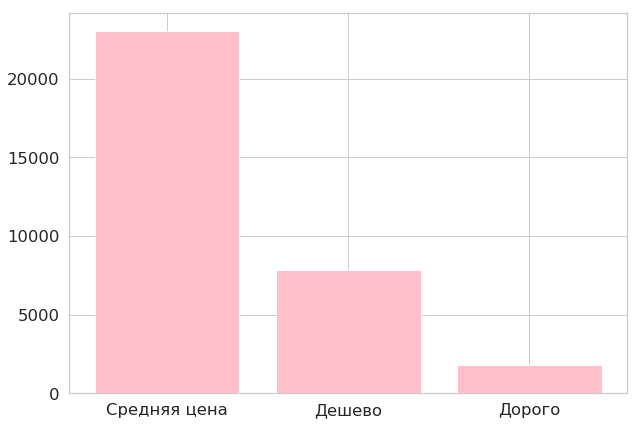

In [846]:
y = data.price_range.value_counts().values
graph = plt.bar(['Средняя цена', 'Дешево', 'Дорого'], y, color='pink')

In [847]:
data.price_range.fillna(common_price, inplace=True)
data.price_range 

0        $$ - $$$
1        $$ - $$$
2        $$ - $$$
3            $$$$
4            $$$$
           ...   
49995    $$ - $$$
49996    $$ - $$$
49997    $$ - $$$
49998    $$ - $$$
49999    $$ - $$$
Name: price_range, Length: 50000, dtype: object

#### Признак reviews
**2 незивестных значения.**

Без ревью нет рейтинга, а целевая переменная - рейтинг.

Соответсвенно нам такие данные не нужны. Можно их удалить.

In [848]:
display(data[data['reviews_is_nan'] == 1])

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,reviews_is_nan,country,cuisine_count
8168,id_8168,Lisbon,European,3389.0,$$ - $$$,2.0,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,0.0,1,1,0,1,Portugal,8
9608,id_9608,Vienna,European,1779.0,$$ - $$$,NaN,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,1,1,1,1,Austria,8


Также удаляем поле reviews_is_nan т.к. оно больше ни на что не влияет

In [849]:
data['reviews'] = data['reviews'].dropna(axis=0)
del data['reviews_is_nan']

#### Новые признаки review_ton_1, review_ton_2, reviews_days_diff
Создаю новые признаки:

review_ton_1, review_ton_2 - тональные окраски двух последних ревью

review_days_diff - количество дней прошедших между ними

Для этого необходим распарсить строковые значения и перевести в формат даты. 

In [850]:
parse_reviews(data)
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,...,number_of_reviews_is_nan,country,cuisine_count,review_1,review_2,review_ton_1,review_ton_2,day_1,day_2,reviews_days_diff
28696,id_1700,Edinburgh,"[Pizza, Fast Food]",1706.0,$,20.0,"[['Poor', 'Delivery During Holiday'], ['11/28/...",/Restaurant_Review-g186525-d6874076-Reviews-Do...,d6874076,1,...,0,United Kingdom,2,Poor,Delivery During Holiday,-0.400,0.000000,2017-11-28,2017-10-24,35.0
1430,id_1430,Krakow,"[Italian, Mediterranean, European, Soups, Vege...",425.0,$$ - $$$,80.0,"[['Good place for lunch!', 'Slightly desappoin...",/Restaurant_Review-g274772-d6756057-Reviews-Tr...,d6756057,0,...,0,Poland,5,Good place for lunch!,Slightly desappointing,0.875,-0.166667,2017-07-11,2017-11-26,138.0
29030,id_936,Rome,[Seafood],937.0,$,96.0,"[['Great place!', 'Great food in a charming pl...",/Restaurant_Review-g187791-d7133805-Reviews-Ri...,d7133805,1,...,0,Italy,1,Great place!,Great food in a charming place,1.000,0.750000,2017-03-25,2016-09-25,181.0
42893,id_769,Budapest,"[Bar, Pub, International]",770.0,$$ - $$$,71.0,"[['Lovely visit:)', 'Great pub'], ['12/13/2017...",/Restaurant_Review-g274887-d2732904-Reviews-Ca...,d2732904,1,...,0,Hungary,3,Lovely visit:),Great pub,0.500,0.800000,2017-12-13,2017-12-09,4.0
27362,id_255,Stockholm,"[French, European, Swedish, Scandinavian, Glut...",256.0,$$$$,156.0,"[['Nice experience', 'Classic fine dining'], [...",/Restaurant_Review-g189852-d1418287-Reviews-Te...,d1418287,1,...,0,Sweden,6,Nice experience,Classic fine dining,0.600,0.291667,2017-08-09,2017-03-05,157.0


In [851]:
data.sort_values(by=['reviews_days_diff']).head(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,...,number_of_reviews_is_nan,country,cuisine_count,review_1,review_2,review_ton_1,review_ton_2,day_1,day_2,reviews_days_diff
24984,id_3313,Rome,[Italian],3314.0,$$ - $$$,94.0,"[['Rustic but very busy'], ['06/24/2013']]",/Restaurant_Review-g187791-d3635889-Reviews-Il...,d3635889,1,...,0,Italy,1,Rustic but very busy,,0.13,0.0,2013-06-24,2013-06-24,0.0
36133,id_3473,Berlin,"[French, African, International, Middle Easter...",3475.0,$$ - $$$,NaN,"[['GREAT HOMEMADE FOOD, wonderful proprietres....",/Restaurant_Review-g187323-d7285453-Reviews-Ar...,d7285453,1,...,1,Germany,5,"GREAT HOMEMADE FOOD, wonderful proprietres...",,0.90,0.0,2014-11-30,2014-11-30,0.0
11241,id_2234,Hamburg,Vegetarian Friendly,2238.0,$$ - $$$,10.0,"[['Nice place'], ['06/23/2017']]",/Restaurant_Review-g187331-d8530236-Reviews-Ge...,d8530236,1,...,0,Germany,19,Nice place,,0.60,0.0,2017-06-23,2017-06-23,0.0
11243,id_5093,Barcelona,"[Seafood, Mediterranean]",5094.0,$$ - $$$,5.0,"[['very comfortable'], ['03/13/2017']]",/Restaurant_Review-g187497-d7322354-Reviews-Va...,d7322354,1,...,0,Spain,2,very comfortable,,0.52,0.0,2017-03-13,2017-03-13,0.0
36114,id_5300,Rome,Italian,5302.0,$$ - $$$,16.0,[['Raccomandato - Enjoy the real roman street....,/Restaurant_Review-g187791-d5815728-Reviews-Il...,d5815728,1,...,0,Italy,7,Raccomandato - Enjoy the real roman street...,,0.30,0.0,2016-06-23,2016-06-23,0.0


#### Признак number_of_reviews
6.4% (3200) неизвестных значений. 

Между **number_of_reviews** и **cuisine_count** имеется средняя позитивная корреляция 0.4. Также, между **number_of_reviews** и **ranking** существует слабая негативная корреляция -0.2. График медианного значения кол-ва отзывов по кол-ву видов кухни показывает то, что в принципе медианное количество отзывов разнится между ресторанами, предлагающими разное количество видов кухонь. В связи с чем заполняю неизвестные значения ресторана медианным значением той группы ресторанов, сгруппированных по кол-ву видов кухни, в которую он квалифицируется. 

In [852]:
data[data['number_of_reviews_is_nan'] == 1].shape[0] / data.shape[0] * 100

6.4

price_range_is_nan         -0.254281
ranking                    -0.223775
cuisine_style_is_nan       -0.195227
reviews_days_diff          -0.138396
cuisine_count              -0.004000
sample                      0.002412
rating                      0.011472
review_ton_1                0.096383
review_ton_2                0.120902
number_of_reviews           1.000000
number_of_reviews_is_nan         NaN
Name: number_of_reviews, dtype: float64


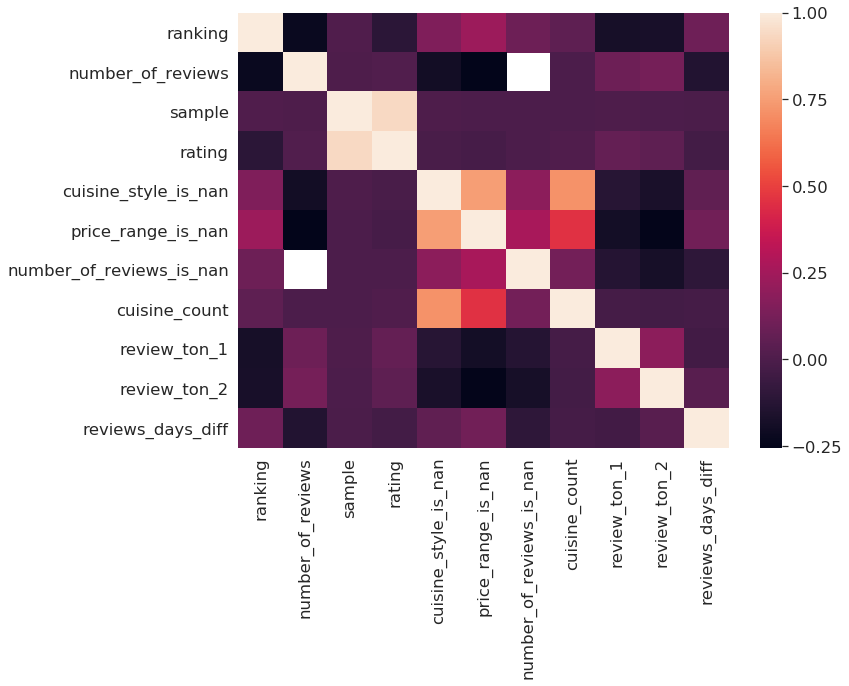

In [853]:
sns.set(rc={'figure.figsize': (11, 8)}, font_scale=1.5, style='whitegrid')
print(data.select_dtypes('number').corr().loc['number_of_reviews'].sort_values())

sns.heatmap(data.select_dtypes('number').corr())

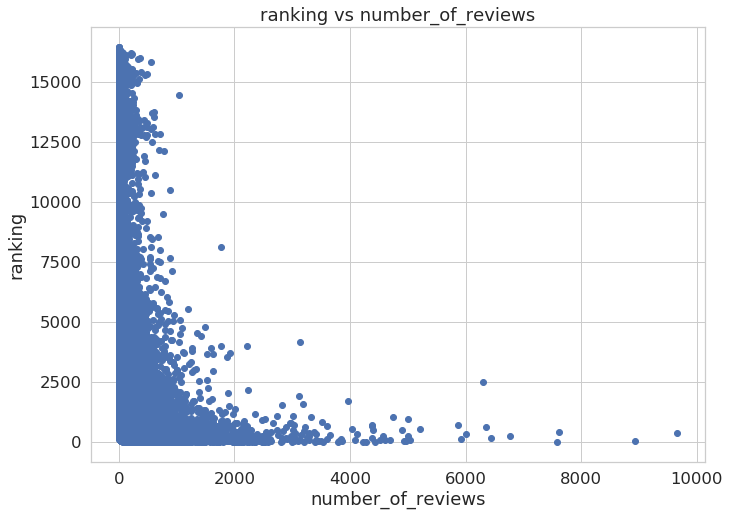

In [854]:
plt.scatter(data.number_of_reviews, data.ranking)
plt.title("ranking vs number_of_reviews")
plt.xlabel("number_of_reviews")
plt.ylabel("ranking")
plt.show()

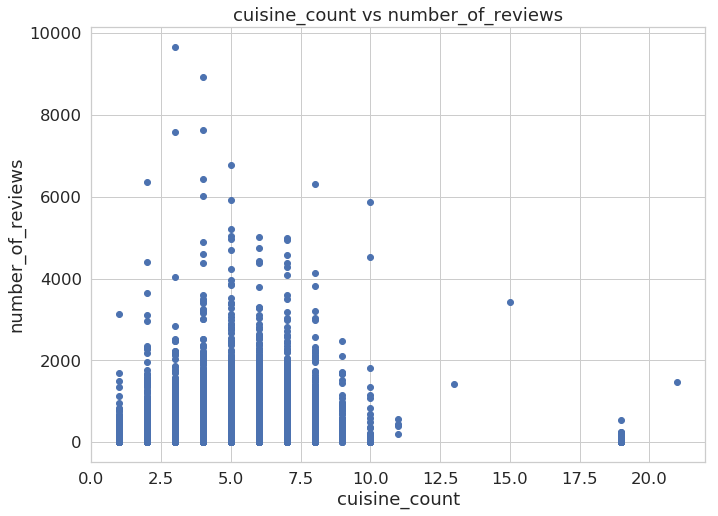

In [855]:
plt.scatter(data.cuisine_count, data.number_of_reviews)
plt.title("cuisine_count vs number_of_reviews")
plt.xlabel("cuisine_count")
plt.ylabel("number_of_reviews")
plt.show()

In [856]:
data.number_of_reviews.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

Разница между средним значением и медианой большая: есть большие выбросы, влияющие сильно на среднее значение. 

In [857]:
print(data.number_of_reviews.mean())
print(data.number_of_reviews.median())
print(data.number_of_reviews.std())

124.47119658119658
33.0
294.1143451116421


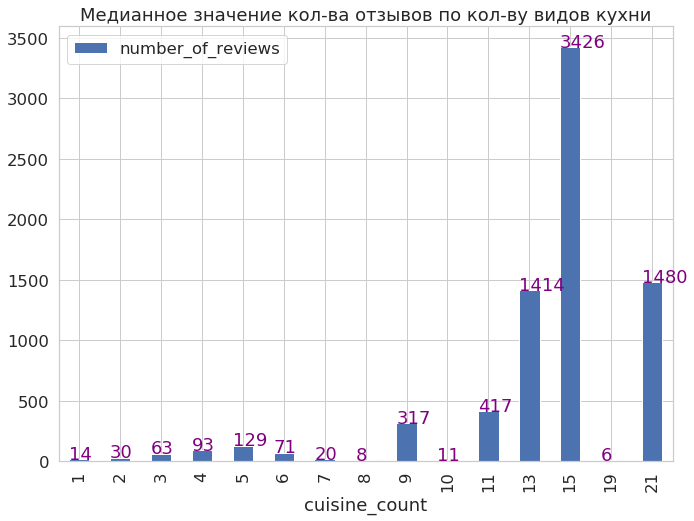

In [858]:
# Вычислить медиану для каждой группы рестроранов, сгруппированных по кол-ву предлагаемых видов кухни. 
reviews_count_data = pd.DataFrame(data.groupby('cuisine_count').median().number_of_reviews)
plot = reviews_count_data.plot.bar(title='Медианное значение кол-ва отзывов по кол-ву видов кухни')
for p in plot.patches:
    plot.annotate(str(int(p.get_height())), (p.get_x(), p.get_height()), color='purple')

In [859]:
# Заполнить неизвестные значения медианой соответсвенно группе, которой принадлежит ресторан. 
data.number_of_reviews = data.apply(
    lambda row: (reviews_count_data.loc[row.cuisine_count])[0]
    if np.isnan(row.number_of_reviews) else row.number_of_reviews,
    axis=1
)

### 1.3 Категоризация признаков

#### 1.3.1 Категориальные (номинативные) признаки.

In [860]:
# Выбрать только нечисловые столбцы. 
nominative = data.select_dtypes('object')
nominative.sample(3)

,restaurant_id,city,cuisine_style,price_range,reviews,url_ta,id_ta,country,review_1,review_2
7146,id_7146,Munich,Vegetarian Friendly,$$ - $$$,"[[], []]",/Restaurant_Review-g187309-d5853144-Reviews-Ga...,d5853144,Germany,,
9533,id_9533,Amsterdam,"[Middle Eastern, Mediterranean, Vegetarian Fri...",$,"[['Wonderful food!', 'Amazing bread with scram...",/Restaurant_Review-g188590-d10464961-Reviews-B...,d10464961,Netherlands,Wonderful food!,Amazing bread with scrambled eggs
37488,id_1420,Prague,"[Czech, Central European, International, Europ...",$,[['Good inexpensive meal and brisk helpful se....,/Restaurant_Review-g274707-d3446795-Reviews-Re...,d3446795,Czechia,Good inexpensive meal and brisk helpful se...,Nice meal friendly staff.


#### 1.3.2 Ординальные признаки

Ординальные признаками являются **ranking**, **price_range**, **rating**, так как их можно по смыслу расставить по возрастанию. 

In [861]:
data.price_range = data.price_range.map({'$': 0, '$$ - $$$': 1, '$$$$': 2})

#### 1.3.3 Числовые признаки

In [862]:
# Выбрать только числовые столбцы. 
numerical = data.select_dtypes('number')
numerical.sample(3)

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,cuisine_count,review_ton_1,review_ton_2,reviews_days_diff
18498,760.0,1,107.0,1,4.0,0,0,0,6,1.000000,0.516667,51.0
36051,14771.0,1,14.0,1,3.0,0,1,1,1,0.225000,0.000000,0.0
8886,15330.0,0,11.0,0,0.0,0,0,0,1,0.077778,0.000000,51.0


## Feature Engineering, обработка новых признаков и РАД

Создаю новые признаки, путем добавления информации из других датасетов, импортированных ранее. 

### Новые признаки **capital**, **is_capital**, **population**, **coastline**, **gdp**, **phones**, **agriculture**, **service**

In [863]:
new_cols = ['country', 'capital', 'population', 'coastline', 'gdp', 'phones', 'agriculture', 'service']
for col in new_cols:
    data[col] = pd.Series(np.array([None] * data.shape[0]))

# Заполнить значения новых признаков в главном датасете с помощью датасета о городах. 
for city_name in data.city.unique():
    if city_name in cities.index:
        try:
            data.loc[(data.city == city_name), 'country'] = cities.loc[city_name].country
            data.loc[(data.city == city_name), 'population'] = int(cities.loc[city_name].population)
        except:
            data.loc[(data.city == city_name), 'country'] = cities.loc[city_name].country.values[0]
            data.loc[(data.city == city_name), 'population'] = int(cities.loc[city_name].population.values[0])

for country_name in data.country.unique():
    if country_name in capitals.index:
        data.loc[data.country == country_name, 'capital'] = capitals.loc[country_name].capital
    if country_name in countries.index:
        for col in ['coastline', 'gdp', 'phones', 'agriculture', 'service']:
            data.loc[data.country == country_name, col] = countries.loc[country_name][col]
data[new_cols]

,country,capital,population,coastline,gdp,phones,agriculture,service
0,France,Paris,11020000,"0,63",27600,"586,4","0,022","0,764"
1,Finland,Helsinki,642045,"0,37",27400,"405,3","0,028","0,676"
2,United Kingdom,London,488050,"5,08",27700,"543,5","0,005","0,758"
3,United Kingdom,London,10979000,"5,08",27700,"543,5","0,005","0,758"
4,Slovakia,Bratislava,429564,"0,00",13300,"220,1","0,035","0,672"
...,...,...,...,...,...,...,...,...
49995,Italy,Rome,1351562,"2,52",26700,"430,9","0,021","0,688"
49996,France,Paris,11020000,"0,63",27600,"586,4","0,022","0,764"
49997,Sweden,Stockholm,972647,"0,72",26800,"715,0","0,011","0,707"
49998,Poland,Warsaw,1790658,"0,16",11100,"306,3","0,05","0,64"


In [864]:
to_change = ['coastline', 'phones', 'agriculture', 'service', 'gdp']
for col in to_change:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '.'), errors='coerce')

In [865]:
data[new_cols]

,country,capital,population,coastline,gdp,phones,agriculture,service
0,France,Paris,11020000,0.63,27600.0,586.4,0.022,0.764
1,Finland,Helsinki,642045,0.37,27400.0,405.3,0.028,0.676
2,United Kingdom,London,488050,5.08,27700.0,543.5,0.005,0.758
3,United Kingdom,London,10979000,5.08,27700.0,543.5,0.005,0.758
4,Slovakia,Bratislava,429564,0.00,13300.0,220.1,0.035,0.672
...,...,...,...,...,...,...,...,...
49995,Italy,Rome,1351562,2.52,26700.0,430.9,0.021,0.688
49996,France,Paris,11020000,0.63,27600.0,586.4,0.022,0.764
49997,Sweden,Stockholm,972647,0.72,26800.0,715.0,0.011,0.707
49998,Poland,Warsaw,1790658,0.16,11100.0,306.3,0.050,0.640


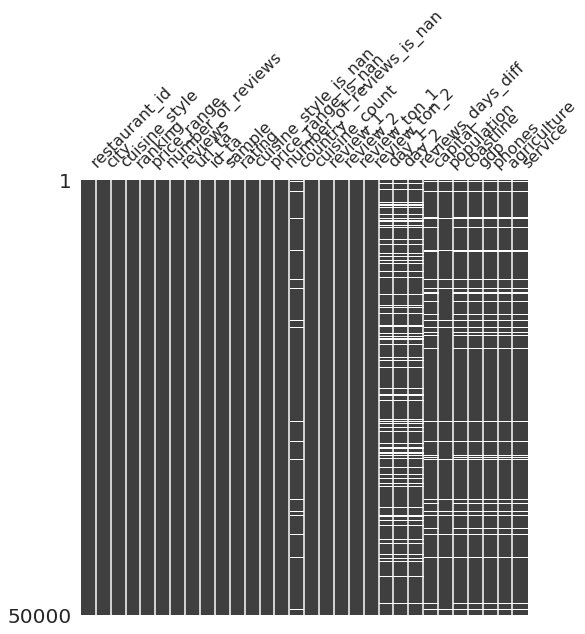

In [866]:
# Проверить в каких новых признаках имеются неизвестные значения.
fig, ax = plt.subplots(figsize=(8, 8))
missin.matrix(data, ax=ax, sparkline=False)

In [867]:
# Заполнить вручную отстутствующие значения для популяции и стран.
data.loc[(data.city == 'Oporto'), 'population'] = 214349
data.loc[(data.city == 'Zurich'), 'population'] = 402762
data.loc[(data.city == 'Krakow'), 'population'] = 766683

data.loc[(data.city == 'Oporto'), 'country'] = 'Portugal'
data.loc[(data.city == 'Zurich'), 'country'] = 'Switzerland'
data.loc[(data.city == 'Krakow'), 'country'] = 'Poland'

In [868]:
# Найти для каких стран нет информации по столицам,ввп и соотношению береговой линии и заполнить вручную.
missing = data[data.capital.isnull()]['country'].unique()
missing_info = {
    'Czechia': ['Prague', 23495, 0],
    'Portugal': ['Lisbon', 23252, 0.98],
    'Poland': ['Warsaw', 15693, 0],
    'Switzerland': ['Bern', 81994, 0]
}

for country in missing:
    for i, col in zip([0, 1, 2], ['capital', 'gdp', 'coastline']):
        data.loc[(data.country == country), col] = missing_info[country][i]

In [869]:
# Создать признак is_capital
new_cols.append('is_capital')
data['is_capital'] = pd.Series(np.array([0] * data.shape[0]))
for capital_name in data.capital.unique():
    data.loc[(data.city == capital_name), 'is_capital'] = 1

In [870]:
data[['country', 'city', 'capital', 'is_capital']].sample(10)

,country,city,capital,is_capital
19164,Austria,Vienna,Vienna,1
47559,Italy,Rome,Rome,1
15296,United Kingdom,Edinburgh,London,0
39322,United Kingdom,London,London,1
34761,United Kingdom,London,London,1
23978,Portugal,Oporto,Lisbon,0
3853,Spain,Madrid,Madrid,1
31011,Ireland,Dublin,Dublin,1
33416,Switzerland,Zurich,Bern,0
32791,United Kingdom,London,London,1


Сервис и агрокультура не сильно разнятся по странам или ВВП, поэтому заполняю пропущенные значения средним значением. 

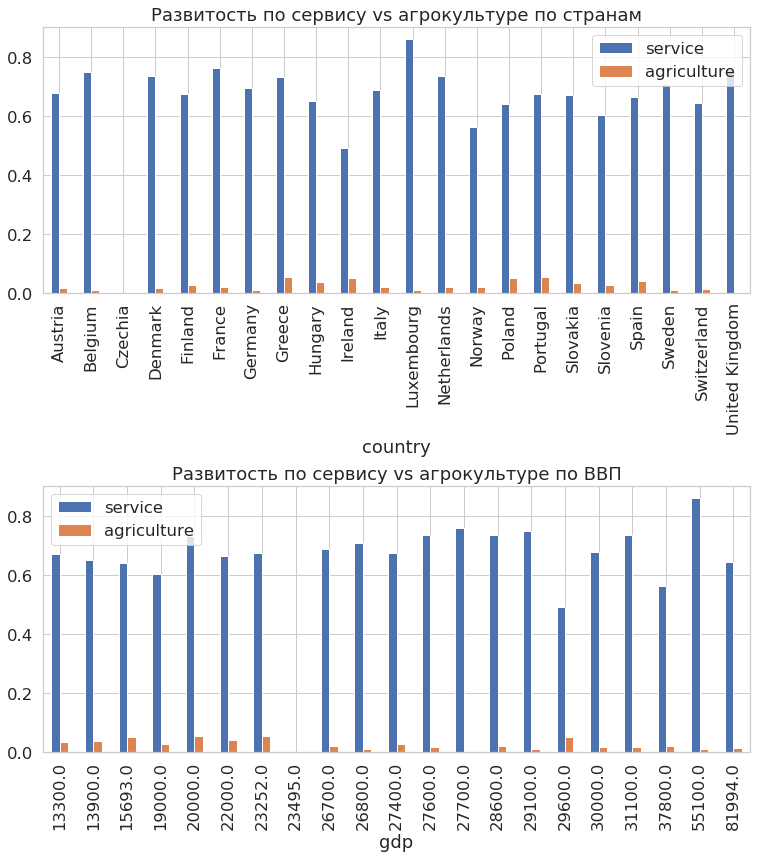

In [871]:
figure, axes = plt.subplots(2, 1, figsize=(15, 15))
figure.tight_layout(pad=9.0)

data.groupby('country')['service', 'agriculture'].mean().plot.bar(
    ax=axes[0],
    rot=90,
    title='Развитость по сервису vs агрокультуре по странам'
)
data.groupby('gdp')['service', 'agriculture'].mean().plot.bar(
    ax=axes[1],
    rot=90,
    title='Развитость по сервису vs агрокультуре по ВВП'
)

In [872]:
data['service'].fillna(data['service'].mean(), inplace=True)
data['agriculture'].fillna(data['agriculture'].mean(), inplace=True)

Пропущенные значения кол-ва телефонов заменяю медианой, так как значения по странам и ВВП разнятся.  

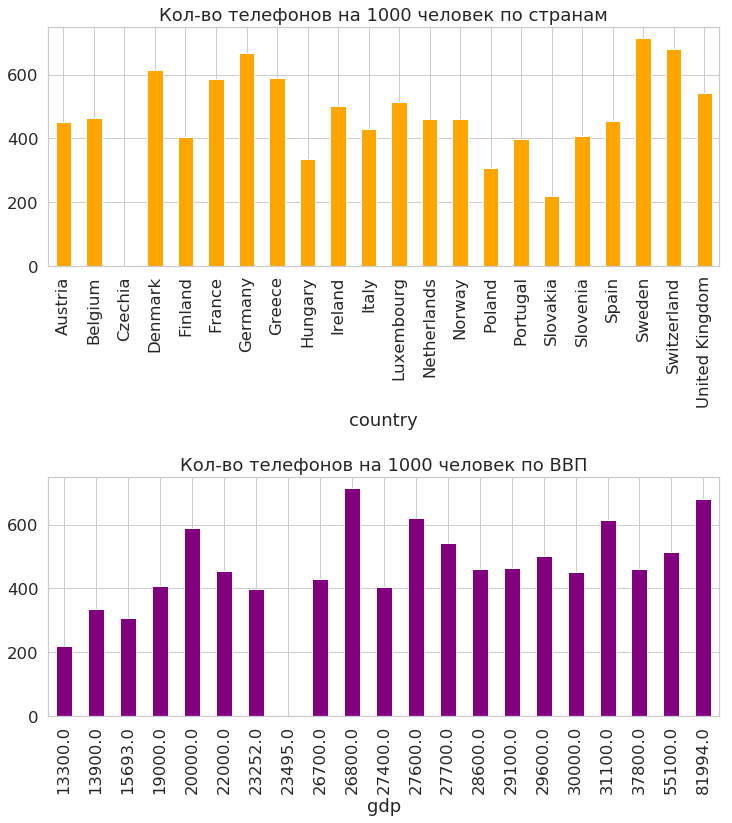

In [873]:
figure, axes = plt.subplots(2, 1, figsize=(15, 15))
figure.tight_layout(pad=10)
data.groupby('country')['phones'].mean().plot.bar(
    ax=axes[0],
    rot=90,
    title='Кол-во телефонов на 1000 человек по странам',
    color='orange'
)
data.groupby('gdp')['phones'].mean().plot.bar(
    ax=axes[1],
    rot=90,
    title='Кол-во телефонов на 1000 человек по ВВП',
    color='purple'
)
plt.show()

In [874]:
data['phones'].fillna(data['phones'].median(), inplace=True)

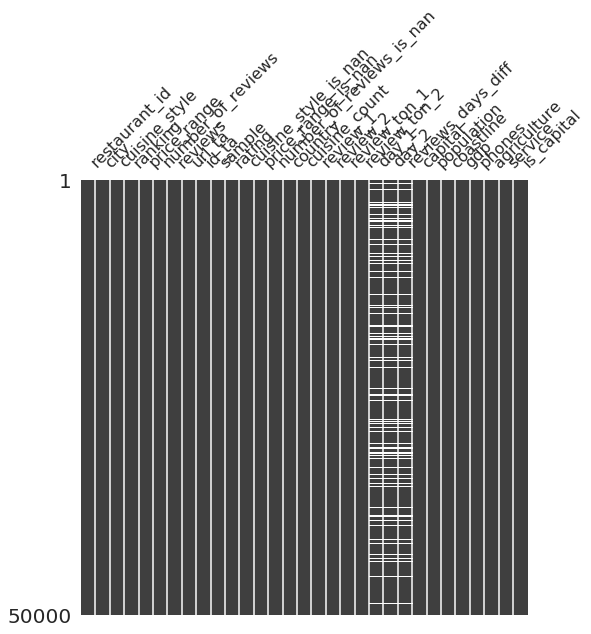

In [875]:
fig, ax = plt.subplots(figsize=(8, 8))
missin.matrix(data, ax=ax, sparkline=False)

Осталось два неизвестных значения, но с ними ничего не делаю, так как они в признаке reviews, которые в модель МО не будет отправляться.

In [876]:
data[data.isnull().any(axis=1)]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,...,day_2,reviews_days_diff,capital,population,coastline,gdp,phones,agriculture,service,is_capital
0,id_0,Paris,"[Bar, Pub]",12963.0,1,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,NaT,NaN,Paris,11020000,0.63,27600.0,586.4,0.022,0.764,1
6,id_6,Lisbon,"[European, Portuguese]",3704.0,0,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,...,NaT,NaN,Lisbon,506654,0.98,23252.0,399.2,0.053,0.673,1
7,id_7,Budapest,European,2330.0,1,8.0,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,...,NaT,NaN,Budapest,1752286,0.00,13900.0,336.2,0.037,0.651,1
18,id_18,Vienna,European,3360.0,1,2.0,"[[], []]",/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,...,NaT,NaN,Vienna,1840573,0.00,30000.0,452.2,0.018,0.678,1
20,id_20,Barcelona,Spanish,6085.0,1,8.0,"[[], []]",/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,...,NaT,NaN,Madrid,4588000,0.98,22000.0,453.5,0.040,0.665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,id_924,Lyon,French,925.0,1,29.0,"[[], []]",/Restaurant_Review-g187265-d5850306-Reviews-Re...,d5850306,1,...,NaT,NaN,Paris,516092,0.63,27600.0,586.4,0.022,0.764,0
49986,id_7274,Madrid,Spanish,7279.0,1,20.0,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,...,NaT,NaN,Madrid,3266126,0.98,22000.0,453.5,0.040,0.665,1
49988,id_4968,Berlin,Vegetarian Friendly,4970.0,1,6.0,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,...,NaT,NaN,Berlin,3644826,0.67,27600.0,667.9,0.009,0.695,1
49991,id_6655,Paris,"[French, Contemporary, Fusion, Gastropub]",6656.0,1,5.0,"[[], []]",/Restaurant_Review-g187147-d13224611-Reviews-L...,d13224611,1,...,NaT,NaN,Paris,11020000,0.63,27600.0,586.4,0.022,0.764,1


### Более подробный анализ признаков **ranking**, так как он должен быть связан с целевой переменной

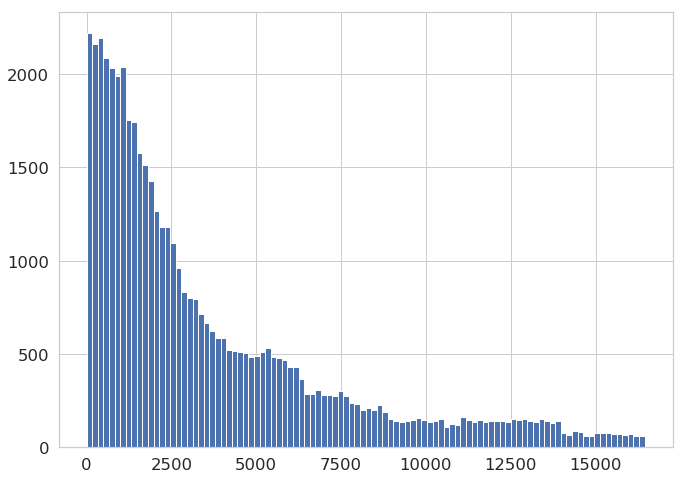

In [877]:
# Посторить распределение ранга ресторанов в общем.
data['ranking'].hist(bins=100)

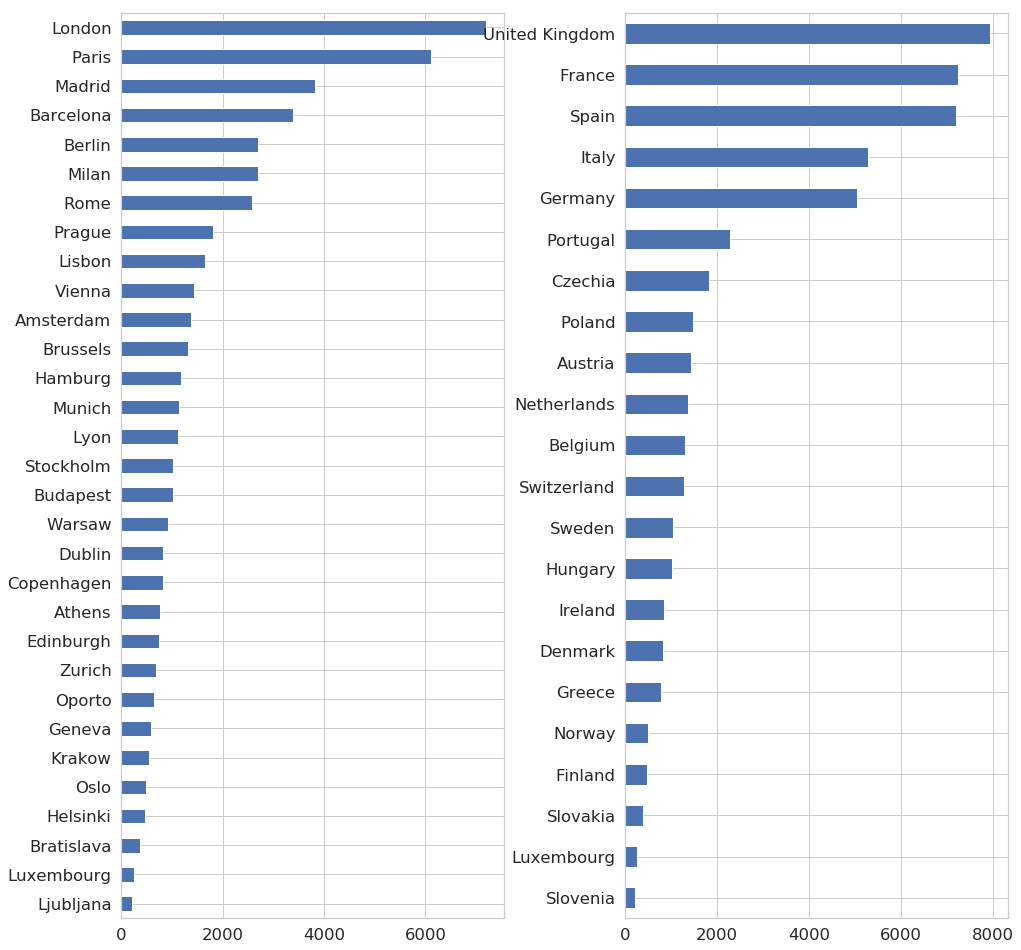

In [878]:
# Рассмотреть количество ресторанов по городам и странам
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
figure.tight_layout(pad=4)
data['city'].value_counts(ascending=True).plot(kind='barh', ax=axes[0])
data['country'].value_counts(ascending=True).plot(kind='barh', ax=axes[1])

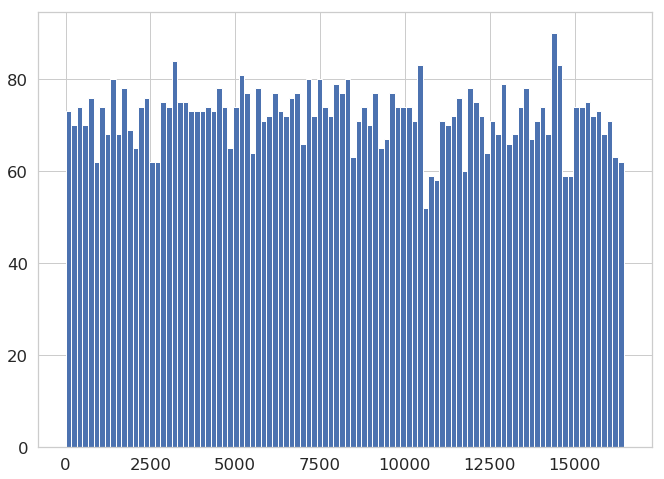

In [879]:
# Рассмотреть распределение ресторанов одного города. 
data['ranking'][data['city'] == 'London'].hist(bins=100)

Из гистограммы ниже следует то,что вероятней всего ранг ресторанов не глобальный, а локальный, то есть в каждом городе в отдельности. 

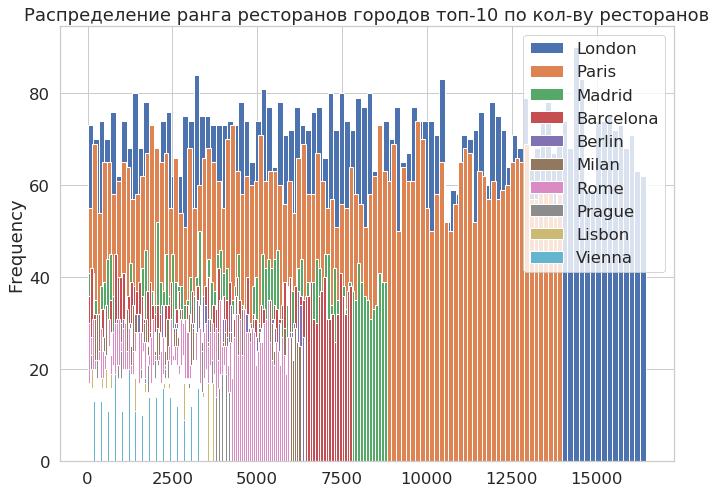

In [880]:
def show_distr(n, by='city', of='ranking', title=''):
    top_n = (data[by].value_counts())[0:n].index
    for x in top_n:
        plot = data[of][data[by] == x].plot(kind='hist', legend=True, bins=100, title=title)
    plot.legend(top_n)
    plt.show()


def normalise(data, by, feature):
    feature_maxes = data.groupby(by)[feature].max()
    return data[[by, feature]].apply(lambda row: row[feature] / feature_maxes.loc[row[by]], axis=1)


show_distr(10, title='Распределение ранга ресторанов городов топ-10 по кол-ву ресторанов')

In [881]:
# Нормализовать переменную с целью подведения под одну шкалу ранг и создать новый признак
data['normalised_rank'] = data['ranking']
data['normalised_rank'] = normalise(data, 'city', 'ranking')
data['normalised_rank']

0        0.926855
1        0.092901
2        0.458664
3        0.101496
4        0.041620
           ...   
49995    0.079681
49996    0.453382
49997    0.670455
49998    0.297586
49999    0.769243
Name: normalised_rank, Length: 50000, dtype: float64

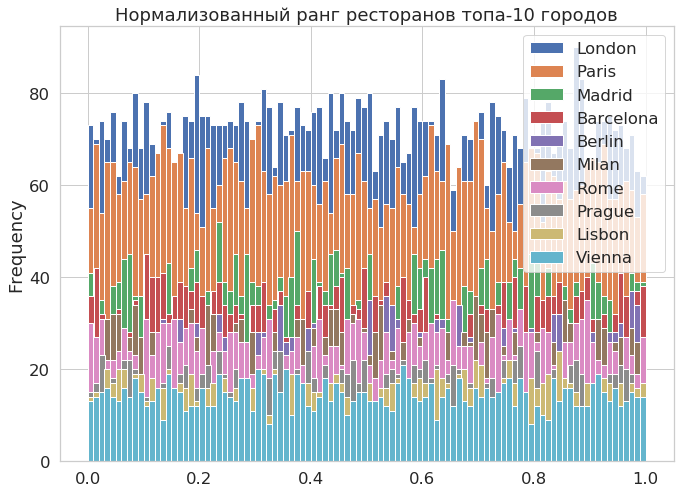

In [882]:
# Показать распределение нового признака нормализованный ранг. 
show_distr(10, 'city', 'normalised_rank', title='Нормализованный ранг ресторанов топа-10 городов')

### Анализ целевой переменной **rating**

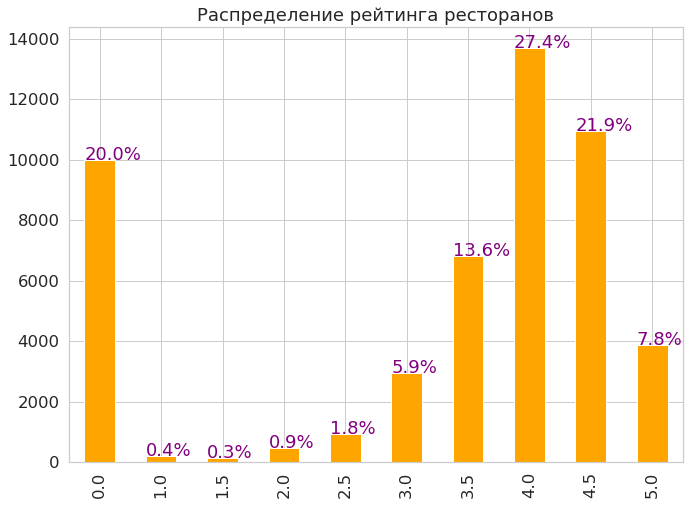

In [883]:
# Постоить гистограмму распределения рейтинга ресторанов.
stats = data['rating'].value_counts(ascending=True).sort_index()
plot = stats.plot(kind='bar', color='orange', title='Распределение рейтинга ресторанов')
for p in plot.patches:
    perc = round(int(p.get_height()) / sum(stats.values) * 100, 1)
    plot.annotate(str(perc) + '%', (p.get_x(), p.get_height()), color='purple')

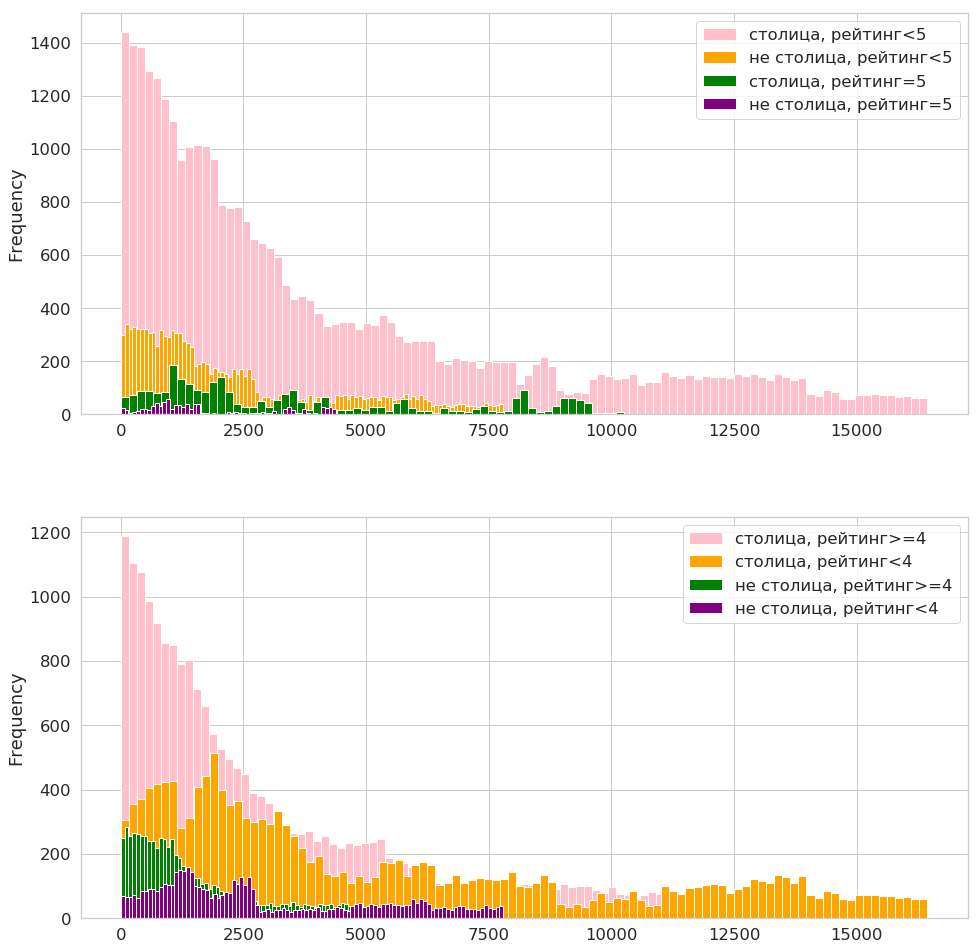

In [884]:
# Построить гистограмму, показувающее соотношение между столичными и ресторанами других городов, а также рейтингом. 
figure, axes = plt.subplots(2, 1, figsize=(15, 15))
figure.tight_layout(pad=4)

# Определить условия в отдельные переменные для удобства.
rating_is_5 = data['rating'] == 5
good_rating = data['rating'] >= 4
is_capital = (data['is_capital'] == 1)
conds = [
    [is_capital & ~rating_is_5, ~is_capital & ~rating_is_5, is_capital & rating_is_5, ~is_capital & rating_is_5],
    [is_capital & good_rating, is_capital & ~good_rating, ~is_capital & good_rating, ~is_capital & ~good_rating]
]

# Вручную составить по соответсвенному порядку названия графиков на одной гистограмме для удобства понимания.
legends = [['столица, рейтинг<5', 'не столица, рейтинг<5', 'столица, рейтинг=5', 'не столица, рейтинг=5'],
           ['столица, рейтинг>=4', 'столица, рейтинг<4', 'не столица, рейтинг>=4', 'не столица, рейтинг<4']]

# Нарисовать графики
for i in range(2):
    for cond, clr in zip(conds[i], ['pink', 'orange', 'green', 'purple']):
        other_tail = data[cond]['ranking'].plot(kind='hist', legend=True, ax=axes[i], bins=100, color=clr)
    other_tail.legend(labels=legends[i])


# Подготовка

In [885]:
md = data.select_dtypes('number').drop_duplicates()

In [886]:
md

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,cuisine_count,review_ton_1,review_ton_2,reviews_days_diff,population,coastline,gdp,phones,agriculture,service,is_capital,normalised_rank
0,12963.0,1,4.0,0,0.0,0,0,0,2,0.00,0.000000,NaN,11020000,0.63,27600.0,586.4,0.022,0.764,1,0.926855
1,106.0,1,97.0,0,0.0,0,0,0,5,1.00,0.416667,37.0,642045,0.37,27400.0,405.3,0.028,0.676,1,0.092901
2,810.0,1,28.0,0,0.0,0,0,0,1,0.50,-0.166667,22.0,488050,5.08,27700.0,543.5,0.005,0.758,0,0.458664
3,1669.0,2,202.0,0,0.0,0,0,0,5,0.75,0.750000,14.0,10979000,5.08,27700.0,543.5,0.005,0.758,1,0.101496
4,37.0,2,162.0,0,0.0,0,0,0,6,1.00,0.910000,15.0,429564,0.00,13300.0,220.1,0.035,0.672,1,0.041620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,1,79.0,1,4.5,0,0,0,4,0.00,1.000000,34.0,1351562,2.52,26700.0,430.9,0.021,0.688,0,0.079681
49996,6341.0,1,542.0,1,3.5,0,0,0,5,0.00,0.600000,9.0,11020000,0.63,27600.0,586.4,0.022,0.764,1,0.453382
49997,1652.0,1,4.0,1,4.5,0,1,0,2,0.70,-0.083333,3127.0,972647,0.72,26800.0,715.0,0.011,0.707,1,0.670455
49998,641.0,1,70.0,1,4.0,0,0,0,5,0.00,0.000000,23.0,1790658,0.00,15693.0,306.3,0.050,0.640,1,0.297586


In [887]:
from sklearn.preprocessing import StandardScaler

scaled_md = md
scaled_md.info()

scaler = StandardScaler()
scaled = scaler.fit_transform(scaled_md)
scaled_md = pd.DataFrame(scaled)
scaled_md.columns = md.columns
scaled_md['sample'] = md['sample']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 20 columns):
ranking                     50000 non-null float64
price_range                 50000 non-null int64
number_of_reviews           50000 non-null float64
sample                      50000 non-null int64
rating                      50000 non-null float64
cuisine_style_is_nan        50000 non-null uint8
price_range_is_nan          50000 non-null uint8
number_of_reviews_is_nan    50000 non-null uint8
cuisine_count               50000 non-null int64
review_ton_1                50000 non-null float64
review_ton_2                50000 non-null float64
reviews_days_diff           41886 non-null float64
population                  50000 non-null int64
coastline                   50000 non-null float64
gdp                         50000 non-null float64
phones                      50000 non-null float64
agriculture                 50000 non-null float64
service                     50000 non-

In [888]:
scaled_md['sample']

0        0
1        0
2        0
3        0
4        0
        ..
49995    1
49996    1
49997    1
49998    1
49999    1
Name: sample, Length: 50000, dtype: int64

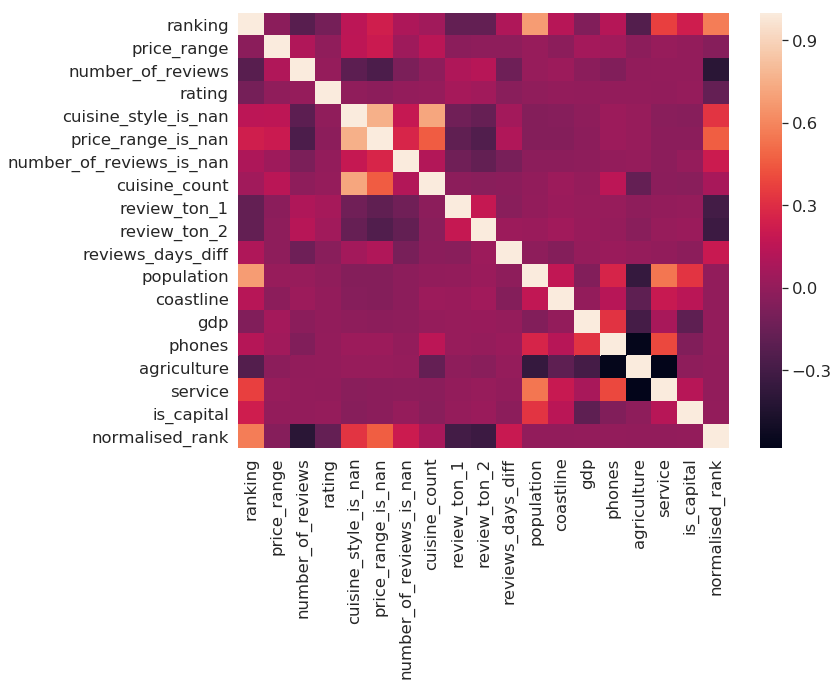

In [889]:
sns.heatmap(scaled_md.drop(['sample'], axis=1).corr(), )


# Обучение модели

In [890]:
data.shape

(50000, 32)

In [891]:
scaled_md.columns

Index(['ranking', 'price_range', 'number_of_reviews', 'sample', 'rating',
       'cuisine_style_is_nan', 'price_range_is_nan',
       'number_of_reviews_is_nan', 'cuisine_count', 'review_ton_1',
       'review_ton_2', 'reviews_days_diff', 'population', 'coastline', 'gdp',
       'phones', 'agriculture', 'service', 'is_capital', 'normalised_rank'],
      dtype='object')

In [896]:
def prepare_model_data(md):
    features = [
        'ranking',
        'price_range',
        'number_of_reviews',
        'cuisine_style_is_nan',
        'price_range_is_nan',
        'number_of_reviews_is_nan',
        'cuisine_count',
        'review_ton_1',
        'review_ton_2',
        'reviews_days_diff',
        'population',
        'coastline',
        'gdp',
        'phones',
        'agriculture',
        'service',
        'is_capital',
        'normalised_rank',
        'sample',
        'rating',
    ]

    result = md[features]
    to_encode = data['city']
    result = pd.concat([result, pd.get_dummies(to_encode)], axis=1)
    result = result.apply(pd.to_numeric, errors='coerce')
    for i in result.columns:
        result.fillna(result[i].mean(), inplace=True)
    return result

#### Запускаем и проверяем что получилось

In [897]:
# Теперь выделим тестовую часть
scaled_md = prepare_model_data(scaled_md)
train_data = scaled_md.query('sample == 1').drop(['sample'], axis=1)
test_data = scaled_md.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values  # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [898]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [899]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

# Model 
Сам ML

In [900]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor  # инструмент для создания и обучения модели
from sklearn import metrics  # инструменты для оценки точности модели

In [901]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [902]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.12001806231379332


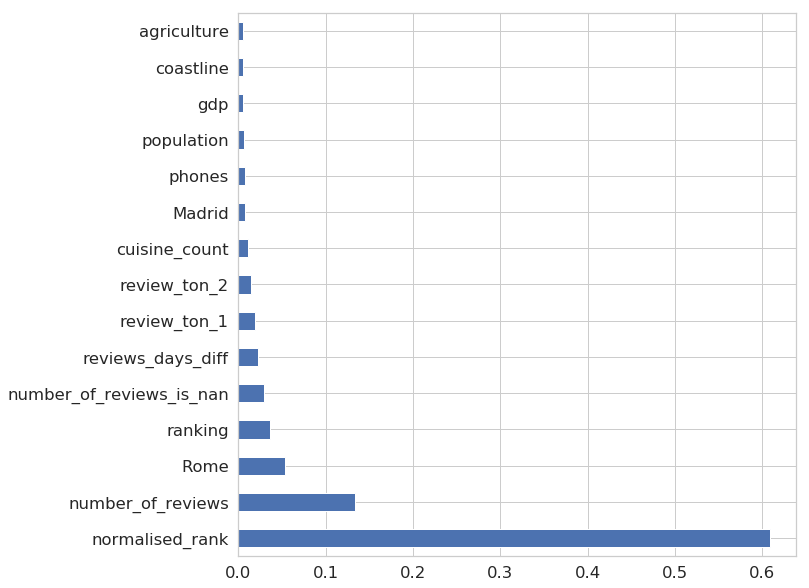

In [903]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission


In [904]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,cuisine_style_is_nan,price_range_is_nan,number_of_reviews_is_nan,cuisine_count,review_ton_1,review_ton_2,reviews_days_diff,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
8451,-0.742267,0.286525,-0.154339,-0.549313,-0.729321,-0.261488,-0.420888,0.434807,-1.516134,-5.560861e-01,...,0,0,0,0,0,0,0,0,0,0
2992,-0.980641,-2.087731,0.724298,-0.549313,-0.729321,-0.261488,0.272342,-1.530622,0.320371,-4.008577e-01,...,0,0,0,0,0,0,0,0,0,0
1386,-0.926318,0.286525,0.143207,-0.549313,-0.729321,-0.261488,0.041266,0.324252,0.069938,-3.397071e-01,...,0,0,0,0,0,0,1,0,0,0
681,-0.870643,0.286525,-0.339868,1.820457,1.371138,-0.261488,0.734496,0.066289,1.822965,-2.503332e-01,...,0,0,0,0,0,0,0,0,0,1
1718,-0.946588,-2.087731,1.445411,-0.549313,-0.729321,-0.261488,0.503419,-0.056550,1.322101,-5.654939e-01,...,0,0,0,0,0,0,0,0,0,0
6726,1.132840,0.286525,-0.388876,1.820457,1.371138,-0.261488,3.276339,1.663200,0.570803,-4.196733e-01,...,0,0,0,0,0,0,0,0,0,0
3898,0.605551,0.286525,-0.343369,1.820457,1.371138,3.824265,0.503419,-0.793586,-0.681359,-9.061529e-17,...,0,0,0,0,0,0,0,0,0,0
1444,0.277448,-2.087731,-0.098331,-0.549313,-0.729321,-0.261488,-0.883041,1.552645,-0.681359,-5.796055e-01,...,0,0,0,0,0,0,0,0,0,0
5913,-0.376596,0.286525,-0.385375,1.820457,1.371138,-0.261488,0.503419,1.663200,-0.681359,-5.796055e-01,...,0,0,0,0,0,0,0,0,0,0
4258,-0.851454,0.286525,-0.339868,-0.549313,-0.729321,-0.261488,0.041266,0.680486,1.322101,-1.468476e-01,...,0,0,0,0,0,0,0,0,1,0


In [905]:
test_data = test_data.drop(['rating'], axis=1)

In [906]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [907]:
predict_submission

array([-0.0465746 ,  0.60135355,  0.79192066, ..., -0.040711  ,
        0.74794363,  0.65119418])

In [908]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('./submission.csv', index=False)
sample_submission.head(10)

,restaurant_id,rating
0,id_0,-0.046575
1,id_1,0.601354
2,id_2,0.791921
3,id_3,0.583763
4,id_4,0.762603
5,id_5,0.762603
6,id_6,-0.937842
7,id_7,0.094152
8,id_8,0.592558
9,id_9,0.809511
